In [2]:
import matplotlib.pyplot as plt
import numpy as np

import texture_segmentation.gabor as gabor

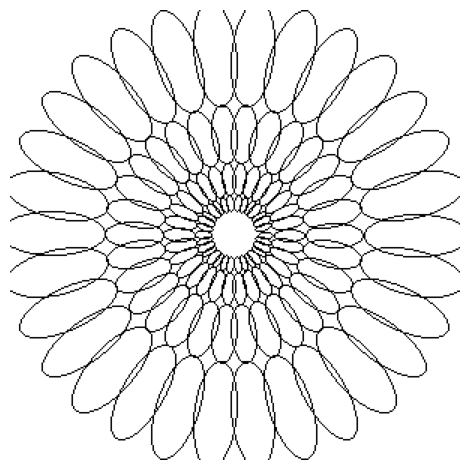

In [7]:
filter_bank_params = {
    'size': 300,
    'num_angles': 30,
    'full_circle': True,
    'scaling_factor': 0.3,
    'num_scales': 4,
    'sigma_x0': 0.2
}

arr = gabor.plot_gabor_filter_bank_fft_fwhm(**filter_bank_params)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.imshow(arr, cmap="binary")
ax.set_axis_off()
plt.tight_layout()
plt.show()